In [1]:
#!pip install  gym-anytrading  gym stable-baselines quantstats

In [2]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading
import quantstats as qs

from stable_baselines import A2C, PPO2
from stable_baselines.common.vec_env import DummyVecEnv

import matplotlib.pyplot as plt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/opt/anaconda3/envs/tf15/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [3]:
df = pd.read_csv('Bitcoin Historical Data - Investing.com.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      703 non-null    object
 1   Price     703 non-null    object
 2   Open      703 non-null    object
 3   High      703 non-null    object
 4   Low       703 non-null    object
 5   Vol.      703 non-null    object
 6   Change %  703 non-null    object
dtypes: object(7)
memory usage: 38.6+ KB


In [4]:
df.Price.replace(',','',regex = True, inplace = True)
df.Open.replace(',','',regex = True, inplace = True)
df.High.replace(',','',regex = True, inplace = True)
df.Low.replace(',','',regex = True, inplace = True)
df['Vol.'].replace(to_replace='K', value='', regex=True, inplace = True)
df['Vol.'].replace(to_replace='M', value='', regex=True, inplace = True)
df['Change %'].replace(to_replace='%', value='', regex=True, inplace = True)
df.iloc[:, 1:] = df.iloc[:, 1:].astype(float, copy = False)
df.Date = pd.to_datetime(df.Date, format = '%b %d, %Y')
df = df.drop(columns=['Change %', 'Vol.'])
df = df.rename(columns = {'Price' : 'Close'})
df.set_index('Date', inplace = True)
df.sort_index(inplace = True)
#df = df.sort_values('Date', ignore_index = True)

df


,Close,Open,High,Low
Date,,,,
2020-03-01,8540.0,8543.8,8737.2,8437.2
2020-03-02,8904.8,8537.5,8961.8,8503.1
2020-03-03,8761.4,8906.1,8911.7,8669.3
2020-03-04,8757.9,8761.3,8840.3,8679.7
2020-03-05,9060.3,8757.9,9147.3,8751.5
...,...,...,...,...
2022-01-28,37745.1,37195.6,37995.9,36176.5
2022-01-29,38170.8,37736.5,38663.7,37350.2
2022-01-30,37917.7,38167.5,38313.3,37390.6


# A2C

## Training Environment

In [10]:
window_size = 50
start_index = window_size + 450
end_index = len(df)


env_maker = lambda: gym.make(
    'stocks-v0',
    df = df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env = DummyVecEnv([env_maker])

In [11]:
#model_train = A2C('MlpLstmPolicy', env, verbose=1) 
#model_train.learn(total_timesteps=20000)

#policy_kwargs = dict(net_arch=[64, 'lstm', dict(vf=[128, 128, 128], pi=[64, 64])])
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

---------------------------------
| explained_variance | 0.000457 |
| fps                | 4        |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 1.27e+06 |
---------------------------------
---------------------------------
| explained_variance | 6.59e-05 |
| fps                | 323      |
| nupdates           | 100      |
| policy_entropy     | 0.693    |
| total_timesteps    | 500      |
| value_loss         | 7.27e+06 |
---------------------------------
----------------------------------
| explained_variance | -6.34e-05 |
| fps                | 485       |
| nupdates           | 200       |
| policy_entropy     | 0.693     |
| total_timesteps    | 1000      |
| value_loss         | 2.81e+06  |
----------------------------------
----------------------------------
| explained_variance | -2.54e-05 |
| fps                | 580       |
| nupdates           | 300       |
| policy_entropy     | 0.693     |
|

## Testing Environment

### Setup

In [16]:
env = env_maker()
observation = env.reset()
rewards = []

while True:
    observation = observation[np.newaxis, ...]

    # action = env.action_space.sample()
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)
    rewards.append(info['total_reward'])

    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': 32031.59999999999, 'total_profit': 1.1680731866864902, 'position': 0}


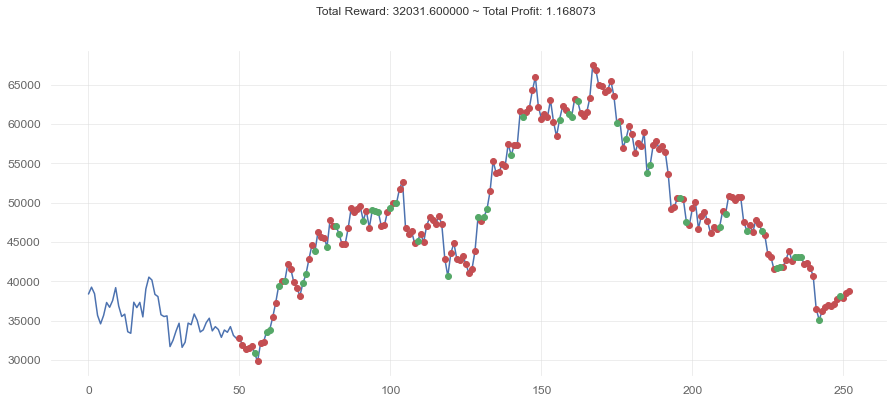

<Figure size 432x288 with 0 Axes>

In [23]:
plt.figure(figsize=(15,6))
plt.cla()
plt.show(env.render_all())
plt.savefig('a2c_buysell.png')

                           Strategy
-------------------------  ----------
Start Period               2021-07-16
End Period                 2022-02-01
Risk-Free Rate             0.0%
Time in Market             16.0%

Cumulative Return          5.91%
CAGR﹪                     11.05%

Sharpe                     0.49
Prob. Sharpe Ratio         66.74%
Smart Sharpe               0.49
Sortino                    0.78
Smart Sortino              0.78
Sortino/√2                 0.55
Smart Sortino/√2           0.55
Omega                      1.21

Max Drawdown               -15.12%
Longest DD Days            92
Volatility (ann.)          17.74%
Calmar                     0.73
Skew                       0.98
Kurtosis                   12.22

Expected Daily %           0.03%
Expected Monthly %         0.72%
Expected Yearly %          2.91%
Kelly Criterion            9.08%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.8%
Expected Shortfall (cVaR)  -1.8%

Max Consecutive Wins       1
M

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-11-01,2022-01-18,2022-02-01,92,-15.118508,-13.540505
2,2021-08-30,2021-09-02,2021-09-15,16,-5.646867,-5.099167
3,2021-09-25,2021-10-13,2021-10-15,20,-3.683488,-2.056069
4,2021-08-11,2021-08-11,2021-08-27,16,-1.558734,-0.429521
5,2021-07-29,2021-07-29,2021-08-07,9,-1.499432,-0.212094


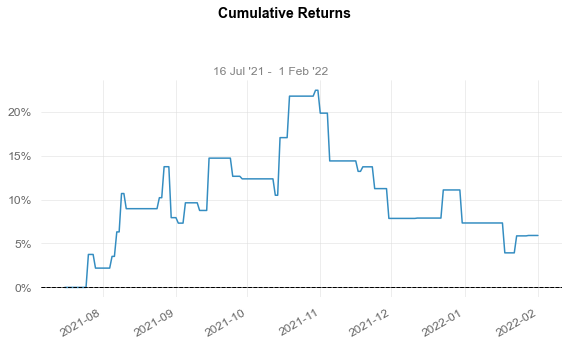

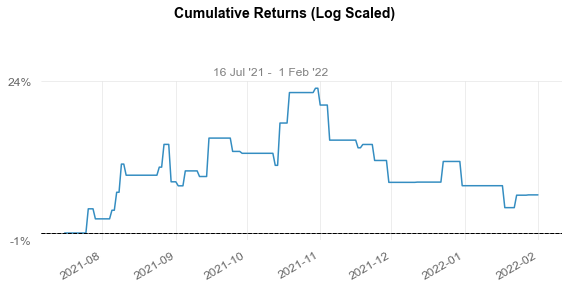

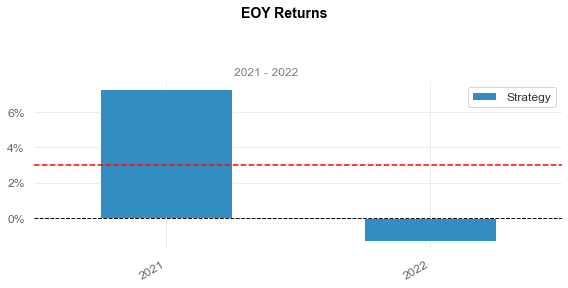

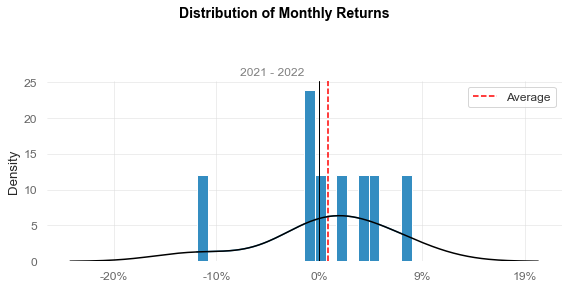

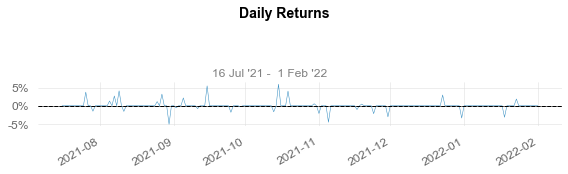

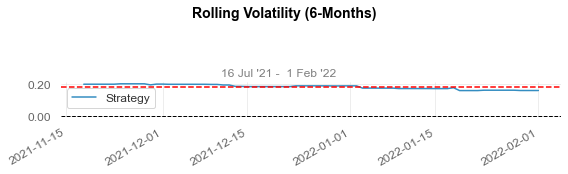

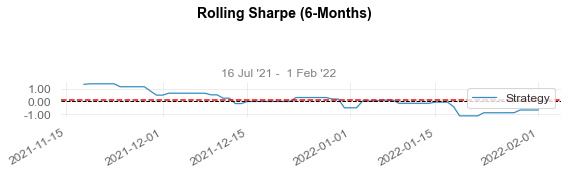

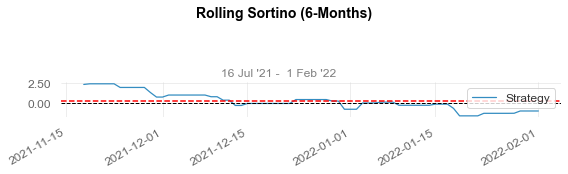

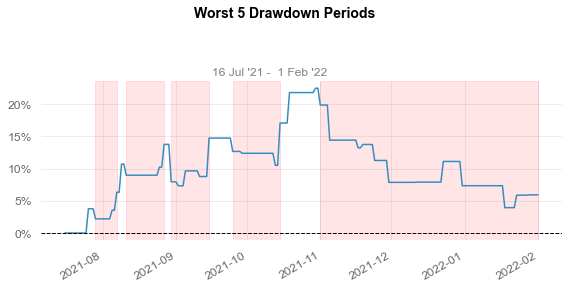

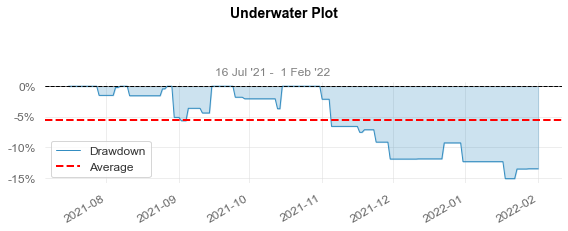

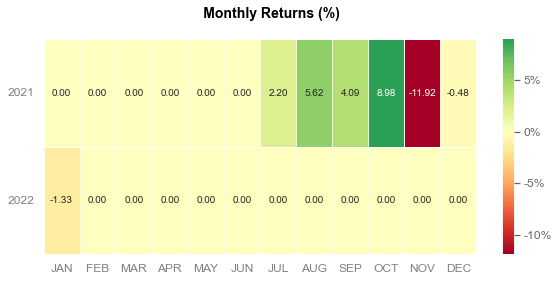

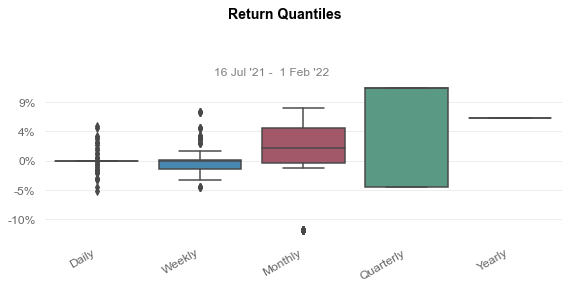

In [14]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='a2c_mlp_quantstats.html')
#type(returns)

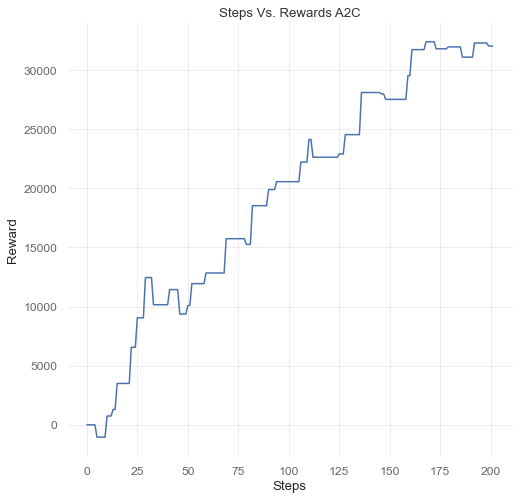

In [20]:
plt.figure(figsize=(8,8))
plt.plot(range(len(rewards)), rewards)
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title('Steps Vs. Rewards A2C')
plt.savefig('a2c_rewards.png')